# Ex14. 트랜스포머로 만드는 대화형 챗봇

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
chatbot_data = pd.read_csv('./transformer_chatbot/data/ChatbotData .csv')
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


## Data Preprocessing

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()

    return sentence

In [5]:
def load_conversations(questions, answers):
    inputs, outputs = [], []
    
    for question, answer in zip(questions, answers):
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
        
    return inputs, outputs

In [6]:
questions, answers = load_conversations(chatbot_data['Q'], chatbot_data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [7]:
print('전처리 후의 25번째 질문 샘플: {}'.format(questions[24]))
print('전처리 후의 25번째 답변 샘플: {}'.format(answers[24]))

전처리 후의 25번째 질문 샘플: 가족 여행 고고
전처리 후의 25번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


In [8]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [9]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [10]:
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [11]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [12]:
print('정수 인코딩 후의 25번째 질문 샘플: {}'.format(tokenizer.encode(questions[24])))
print('정수 인코딩 후의 25번째 답변 샘플: {}'.format(tokenizer.encode(answers[24])))

정수 인코딩 후의 25번째 질문 샘플: [5755, 429, 4601]
정수 인코딩 후의 25번째 답변 샘플: [1087, 3174, 591, 264, 877, 621, 288, 1]


In [13]:
MAX_LENGTH = 40
print(MAX_LENGTH)

40


## Various Functions (filter, attention, mask...)

In [14]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :', (VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 샘플 개수: 11823
필터링 후의 샘플 개수: 11823


In [16]:
# PositionalEncoding
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [17]:
# scaled_dot_product_attention
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

In [19]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [20]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## Encoder Layer and Encoder,   
## Decoder Layer and Decoder

In [21]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [22]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [24]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### Training

In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # encoder
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # decoder
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(
        units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [27]:
tf.keras.backend.clear_session()

NUM_LAYERS = 6  # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13653504    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Parts of Parameters

In [30]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### Confirmation

Epoch 1/40
185/185 [==============================] - 67s 210ms/step - loss: 1.3448 - accuracy: 0.0224
Epoch 2/40
185/185 [==============================] - 40s 217ms/step - loss: 1.0768 - accuracy: 0.0476
Epoch 3/40
185/185 [==============================] - 41s 222ms/step - loss: 0.9827 - accuracy: 0.0508
Epoch 4/40
185/185 [==============================] - 41s 219ms/step - loss: 0.9408 - accuracy: 0.0525
Epoch 5/40
185/185 [==============================] - 41s 221ms/step - loss: 0.9066 - accuracy: 0.0545
Epoch 6/40
185/185 [==============================] - 41s 220ms/step - loss: 0.8701 - accuracy: 0.0566
Epoch 7/40
185/185 [==============================] - 41s 220ms/step - loss: 0.8300 - accuracy: 0.0588
Epoch 8/40
185/185 [==============================] - 41s 221ms/step - loss: 0.7829 - accuracy: 0.0616
Epoch 9/40
185/185 [==============================] - 41s 220ms/step - loss: 0.7309 - accuracy: 0.0655
Epoch 10/40
185/185 [==============================] - 41s 220ms/step - l

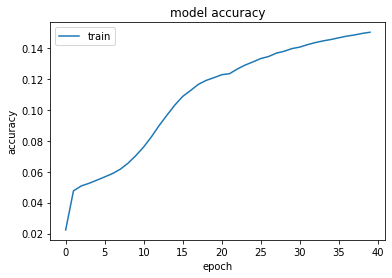

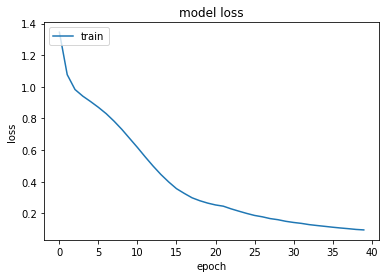

In [31]:
EPOCHS = 40
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(dataset, epochs=EPOCHS, verbose=1,callbacks=[callback])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Inference

In [32]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [33]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [34]:
sentence_generation("나의 꿈은 이루어질까?")

입력 : 나의 꿈은 이루어질까?
출력 : 위험하네요 .


'위험하네요 .'

In [35]:
sentence_generation("뭐가 위험하다는 건지 설명좀 부탁해")

입력 : 뭐가 위험하다는 건지 설명좀 부탁해
출력 : 사랑 받기 위해 태어났어요 .


'사랑 받기 위해 태어났어요 .'

In [36]:
sentence_generation("그건 알아. 그래도 사람은 더 높은 곳을 향하고 싶어하지. 그것이 꼭 위험한 것은 아니야")

입력 : 그건 알아. 그래도 사람은 더 높은 곳을 향하고 싶어하지. 그것이 꼭 위험한 것은 아니야
출력 : 그 사람을 무의식 중에 생각했나봅니다 .


'그 사람을 무의식 중에 생각했나봅니다 .'

In [37]:
sentence_generation("그 사람? 누구?")

입력 : 그 사람? 누구?
출력 : 저는 고민이 없어요 .


'저는 고민이 없어요 .'

<회고>

* 복잡한 트랜스포머의 구조에서도 크게는 인코더와 디코더(+어텐션)로     
  나누어져 있음을 알았다.  

* RNN과 달리 padding mask와 look_ahead mask의 개념이 더 추가된 것 같다.

* 인공지능 챗봇과 대화를 해보았다.  

* 첫 질문에 대한 챗봇의 대답(위험하네요)이 나에게 다른 의문을 낳아서 계속 질문을   
  던지는 방식을 시도했다.

* 중간에 심한 어색함은 나타나지 않았고 대화가 이어지는 걸로 봐서  
  챗봇은 문장 하나를 학습하는 것 외에 연이은 문장에 대해 학습하는 걸로 보인다. 
  
* 비교적 긴 문장에도 대답을 하는 걸로 봐서 똑똑하다는 느낌이 든다.    
  
* 전반적으로 이 정도면 약간 어색하긴 해도 성능이 나쁘지는 않은 것 같다.   